# Решение задачи с помощью Crisp DM

Так сложилось, что данную задачу мне уже приходилось решать, а потому возьму за основу уже имеющийся ноутбук, оформив решение в терминах Crisp DM и добавив некоторые дополнительные этапы.

## Bussiness-understanding

О бизнес-анализу в данном случае говорить не приходится, так как задача сама по себе является учебной и в нашем случае бизнес-контекст отсутсвует.

В данном случае это делает нецелесообразными этапы:
- составление бизнес-фона
- определение бизнес-целей
- критерии успеха проекта с точки зрения бизнеса
- и пр.

In [1]:
import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn

import numpy as np
import pandas as pd
import pylab 
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import ListedColormap
%matplotlib inline
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D
from graphviz import Source
from IPython.display import Image

from scipy.stats import skew, norm, probplot, boxcox, f_oneway
from scipy import interp
from sklearn.base import BaseEstimator, TransformerMixin, clone, ClassifierMixin
from sklearn import metrics, tree
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler, PolynomialFeatures, MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier

## Data-understanding
Загрузим датасет и разделим целевые сорта на 3 категории для сведения задачи к классификации

In [2]:
wines = pd.read_csv('winequalityN.csv')

wines['quality_label'] = wines.quality.apply(lambda q: 'low' if q <= 5 else 'medium' if q <= 7 else 'high')
wines = wines.sample(frac=1, random_state=101).reset_index(drop=True)

In [3]:
wines.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_label
0,white,7.3,0.28,0.42,14.4,0.040,49.0,173.0,0.99940,3.28,0.82,9.0,7,medium
1,red,6.9,1.09,0.06,2.1,0.061,12.0,31.0,0.99480,3.51,0.43,11.4,4,low
2,red,9.5,0.46,0.24,2.7,0.092,14.0,44.0,0.99800,3.12,0.74,10.0,6,medium
3,red,8.2,0.31,0.40,2.2,0.058,6.0,10.0,0.99536,3.31,0.68,11.2,7,medium
4,white,7.9,0.28,0.41,4.9,0.058,31.0,153.0,0.99660,3.27,0.51,9.7,6,medium


#### Убираем пропуски

In [4]:
wines.quality_label.value_counts()

medium    3915
low       2384
high       198
Name: quality_label, dtype: int64

In [5]:
wines.dropna().quality_label.value_counts()

medium    3894
low       2372
high       197
Name: quality_label, dtype: int64

In [6]:
wines.dropna(inplace=True)

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """
        Impute missing values:
        - Columns of dtype object are imputed with the most frequent value in column.
        - Columns of other types are imputed with mean of column.
        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

wines = DataFrameImputer().fit_transform(wines)

Посмотрим теперь на распределение данных в разрезах качества и сортов вин

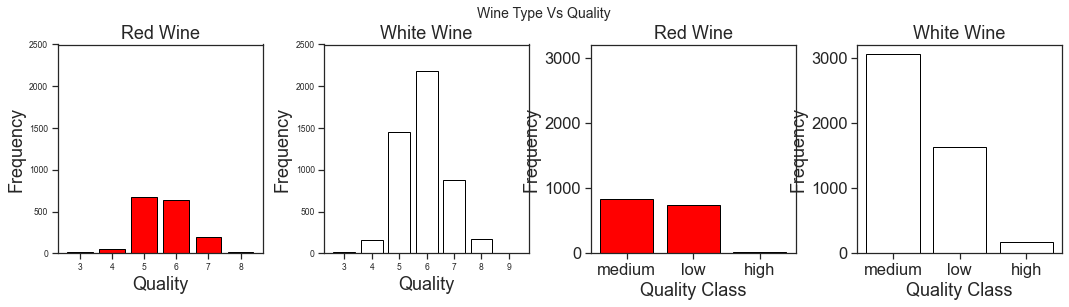

In [7]:
fig = plt.figure(figsize = (18, 4))
title = fig.suptitle("Wine Type Vs Quality", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,4, 1)
ax1.set_title("Red Wine")
ax1.set_xlabel("Quality")
ax1.set_ylabel("Frequency") 
rw_q = wines.quality[wines.type == 'red'].value_counts()
rw_q = (list(rw_q.index), list(rw_q.values))
ax1.set_ylim([0, 2500])
ax1.tick_params(axis='both', which='major', labelsize=8.5)
bar1 = ax1.bar(rw_q[0], rw_q[1], color='red', edgecolor='black', linewidth=1)


ax2 = fig.add_subplot(1,4, 2)
ax2.set_title("White Wine")
ax2.set_xlabel("Quality")
ax2.set_ylabel("Frequency") 
ww_q = wines.quality[wines.type == 'white'].value_counts()
ww_q = (list(ww_q.index), list(ww_q.values))
ax2.set_ylim([0, 2500])
ax2.tick_params(axis='both', which='major', labelsize=8.5)
bar2 = ax2.bar(ww_q[0], ww_q[1], color='white', edgecolor='black', linewidth=1)

ax3 = fig.add_subplot(1,4, 3)
ax3.set_title("Red Wine")
ax3.set_xlabel("Quality Class")
ax3.set_ylabel("Frequency") 
rw_q = wines.quality_label[wines.type == 'red'].value_counts()
rw_q = (list(rw_q.index), list(rw_q.values))
ax3.set_ylim([0, 3200])
bar3 = ax3.bar(list(range(len(rw_q[0]))), rw_q[1], color='red', edgecolor='black', linewidth=1, tick_label =rw_q[0])

ax4 = fig.add_subplot(1,4, 4)
ax4.set_title("White Wine")
ax4.set_xlabel("Quality Class")
ax4.set_ylabel("Frequency") 
ww_q = wines.quality_label[wines.type == 'white'].value_counts()
ww_q = (list(ww_q.index), list(ww_q.values))
ax4.set_ylim([0, 3200])
bar4 = ax4.bar(list(range(len(ww_q[0]))), ww_q[1], color='white', edgecolor='black', linewidth=1, tick_label =ww_q[0])

Посмотрим на статистики в разрезах вида вина и его качества

In [8]:
subset_attributes = wines.columns
rs = round(wines.loc[wines.type == 'red', subset_attributes].describe(),2)
ws = round(wines.loc[wines.type == 'white', subset_attributes].describe(),2)
pd.concat([rs, ws], axis=0, keys=['Red Wine Statistics', 'White Wine Statistics']).T

Red Wine Statistics                                    \
                                   count   mean    std   min    25%    50%   
fixed acidity                     1593.0   8.33   1.74  4.60   7.10   7.90   
volatile acidity                  1593.0   0.53   0.18  0.12   0.39   0.52   
citric acid                       1593.0   0.27   0.19  0.00   0.09   0.26   
residual sugar                    1593.0   2.54   1.41  0.90   1.90   2.20   
chlorides                         1593.0   0.09   0.05  0.01   0.07   0.08   
free sulfur dioxide               1593.0  15.84  10.44  1.00   7.00  14.00   
total sulfur dioxide              1593.0  46.46  32.91  6.00  22.00  38.00   
density                           1593.0   1.00   0.00  0.99   1.00   1.00   
pH                                1593.0   3.31   0.15  2.74   3.21   3.31   
sulphates                         1593.0   0.66   0.17  0.33   0.55   0.62   
alcohol                           1593.0  10.42   1.07  8.40   9.50  10.20   
quality                           1593.0   5.64   0.81  3.00   5.00   6.00   

                                    White Wine Statistics                 \
                        75%     max                 count    mean    std   
fixed acidity          9.20   15.90                4870.0    6.86   0.84   
volatile acidity       0.64    1.58                4870.0    0.28   0.10   
citric acid            0.42    1.00                4870.0    0.33   0.12   
residual sugar         2.60   15.50                4870.0    6.39   5.07   
chlorides              0.09    0.61                4870.0    0.05   0.02   
free sulfur dioxide   21.00   72.00                4870.0   35.32  17.01   
total sulfur dioxide  62.00  289.00                4870.0  138.34  42.49   
density                1.00    1.00                4870.0    0.99   0.00   
pH                     3.40    4.01                4870.0    3.19   0.15   
sulphates              0.73    2.00                4870.0    0.49   0.11   
alcohol               11.10   14.90                4870.0   10.52   1.23   
quality                6.00    8.00                4870.0    5.88   0.89   

                                                            
                       min     25%     50%     75%     max  
fixed acidity         3.80    6.30    6.80    7.30   14.20  
volatile acidity      0.08    0.21    0.26    0.32    1.10  
citric acid           0.00    0.27    0.32    0.39    1.66  
residual sugar        0.60    1.70    5.20    9.90   65.80  
chlorides             0.01    0.04    0.04    0.05    0.35  
free sulfur dioxide   2.00   23.00   34.00   46.00  289.00  
total sulfur dioxide  9.00  108.00  134.00  167.00  440.00  
density               0.99    0.99    0.99    1.00    1.04  
pH                    2.72    3.09    3.18    3.28    3.82  
sulphates             0.22    0.41    0.47    0.55    1.08  
alcohol               8.00    9.50   10.40   11.40   14.20  
quality               3.00    5.00    6.00    6.00    9.00

In [9]:
#subset_attributes = ['alcohol', 'volatile acidity', 'pH', 'quality']
ls = round(wines[wines['quality_label'] == 'low'][subset_attributes].describe(),2)
ms = round(wines[wines['quality_label'] == 'medium'][subset_attributes].describe(),2)
hs = round(wines[wines['quality_label'] == 'high'][subset_attributes].describe(),2)
pd.concat([ls, ms, hs], axis=0, keys=['Low Quality Wine', 'Medium Quality Wine', 'High Quality Wine']).T

Low Quality Wine                                      \
                                count    mean    std   min    25%     50%   
fixed acidity                  2372.0    7.33   1.27  4.20   6.50    7.10   
volatile acidity               2372.0    0.40   0.19  0.10   0.26    0.34   
citric acid                    2372.0    0.30   0.16  0.00   0.21    0.30   
residual sugar                 2372.0    5.63   4.91  0.60   1.80    2.90   
chlorides                      2372.0    0.06   0.04  0.01   0.04    0.05   
free sulfur dioxide            2372.0   29.48  19.86  2.00  14.00   26.00   
total sulfur dioxide           2372.0  119.21  61.90  6.00  68.00  124.00   
density                        2372.0    1.00   0.00  0.99   0.99    1.00   
pH                             2372.0    3.21   0.16  2.74   3.11    3.20   
sulphates                      2372.0    0.52   0.14  0.25   0.44    0.50   
alcohol                        2372.0    9.87   0.84  8.00   9.30    9.60   
quality                        2372.0    4.88   0.36  3.00   5.00    5.00   

                                     Medium Quality Wine          ...          \
                         75%     max               count    mean  ...     75%   
fixed acidity           7.80   15.90              3894.0    7.17  ...    7.60   
volatile acidity        0.50    1.58              3894.0    0.31  ...    0.36   
citric acid             0.40    1.00              3894.0    0.33  ...    0.39   
residual sugar          8.50   23.50              3894.0    5.33  ...    7.90   
chlorides               0.08    0.61              3894.0    0.05  ...    0.06   
free sulfur dioxide    42.00  289.00              3894.0   30.94  ...   41.00   
total sulfur dioxide  167.00  440.00              3894.0  113.45  ...  150.00   
density                 1.00    1.00              3894.0    0.99  ...    1.00   
pH                      3.31    3.90              3894.0    3.22  ...    3.32   
sulphates               0.58    2.00              3894.0    0.54  ...    0.61   
alcohol                10.40   14.90              3894.0   10.81  ...   11.70   
quality                 5.00    5.00              3894.0    6.28  ...    7.00   

                             High Quality Wine                               \
                         max             count    mean    std    min    25%   
fixed acidity          15.60             197.0    6.85   1.15   3.90   6.20   
volatile acidity        1.04             197.0    0.29   0.12   0.12   0.21   
citric acid             1.66             197.0    0.33   0.10   0.03   0.28   
residual sugar         65.80             197.0    5.37   4.16   0.80   2.00   
chlorides               0.42             197.0    0.04   0.02   0.01   0.03   
free sulfur dioxide   112.00             197.0   34.53  17.12   3.00  24.00   
total sulfur dioxide  294.00             197.0  117.70  41.69  12.00  96.00   
density                 1.04             197.0    0.99   0.00   0.99   0.99   
pH                      4.01             197.0    3.22   0.16   2.88   3.13   
sulphates               1.95             197.0    0.51   0.16   0.25   0.38   
alcohol                14.20             197.0   11.69   1.27   8.50  11.00   
quality                 7.00             197.0    8.03   0.16   8.00   8.00   

                                              
                         50%     75%     max  
fixed acidity           6.80    7.30   12.60  
volatile acidity        0.27    0.35    0.85  
citric acid             0.32    0.36    0.74  
residual sugar          4.10    7.60   14.80  
chlorides               0.04    0.04    0.12  
free sulfur dioxide    34.00   43.00  105.00  
total sulfur dioxide  119.00  145.00  212.50  
density                 0.99    0.99    1.00  
pH                      3.23    3.33    3.72  
sulphates               0.48    0.60    1.10  
alcohol                12.00   12.60   14.00  
quality                 8.00    8.00    9.00  

[12 rows x 24 columns]

In [10]:
def type_inf_stat_test(feature):
    F, p = f_oneway(wines[wines.type == 'red'][feature], 
                    wines[wines.type == 'white'][feature])
    if p <= 0.05:
        msg = 'Reject'
    else:
        msg = 'Acept'
    print('F Statistic: {:.2f} \tp-value: {:.3f} \tNull Hypothesis: {}'.format(F, p, msg))
    
def quality_inf_stat_test(feature):
    F, p = f_oneway(wines[wines.quality_label == 'low'][feature], 
                    wines[wines.quality_label == 'medium'][feature], 
                    wines[wines.quality_label == 'high'][feature])
    if p <= 0.05:
        msg = 'Reject'
    else:
        msg = 'Acept'
    print('F Statistic: {:.2f} \tp-value: {:.3f} \tNull Hypothesis: {}'.format(F, p, msg))

Проверим корреляции между признаками

In [11]:
wines = wines.sample(frac=1, random_state=101).reset_index(drop=True)

class_tp = LabelEncoder()
y_tp = class_tp.fit_transform(wines.type.values) # 1 - White; 0 - Red
wines['color'] = y_tp

class_ql = {'low':0, 'medium': 1, 'high': 2}
y_ql = wines.quality_label.map(class_ql)

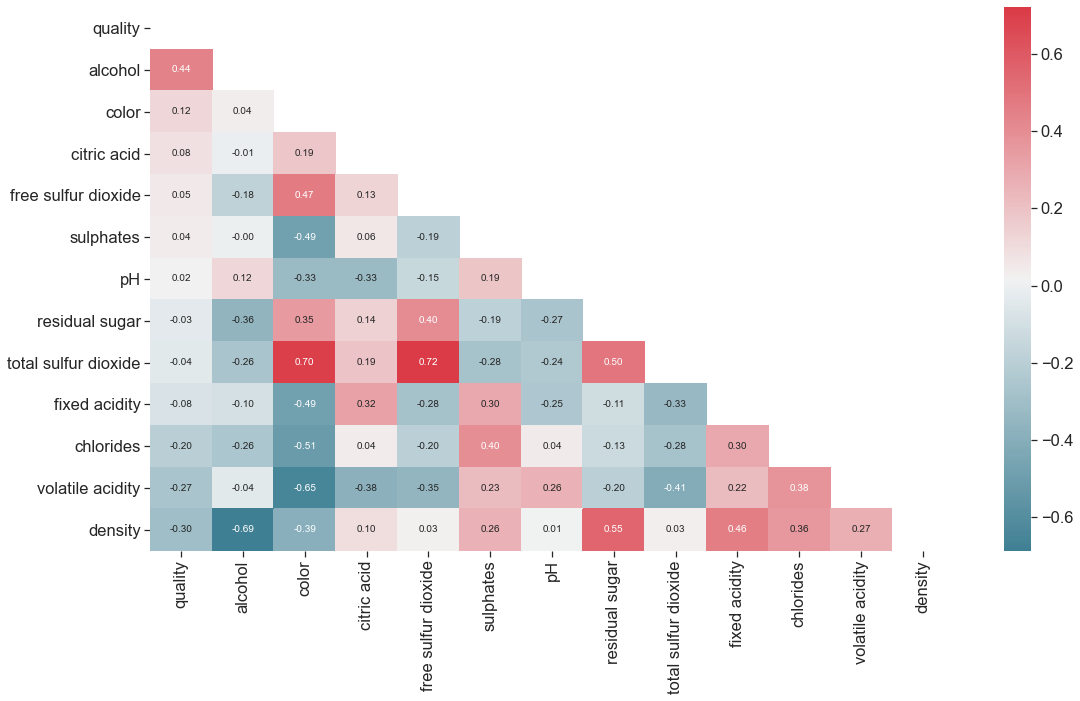

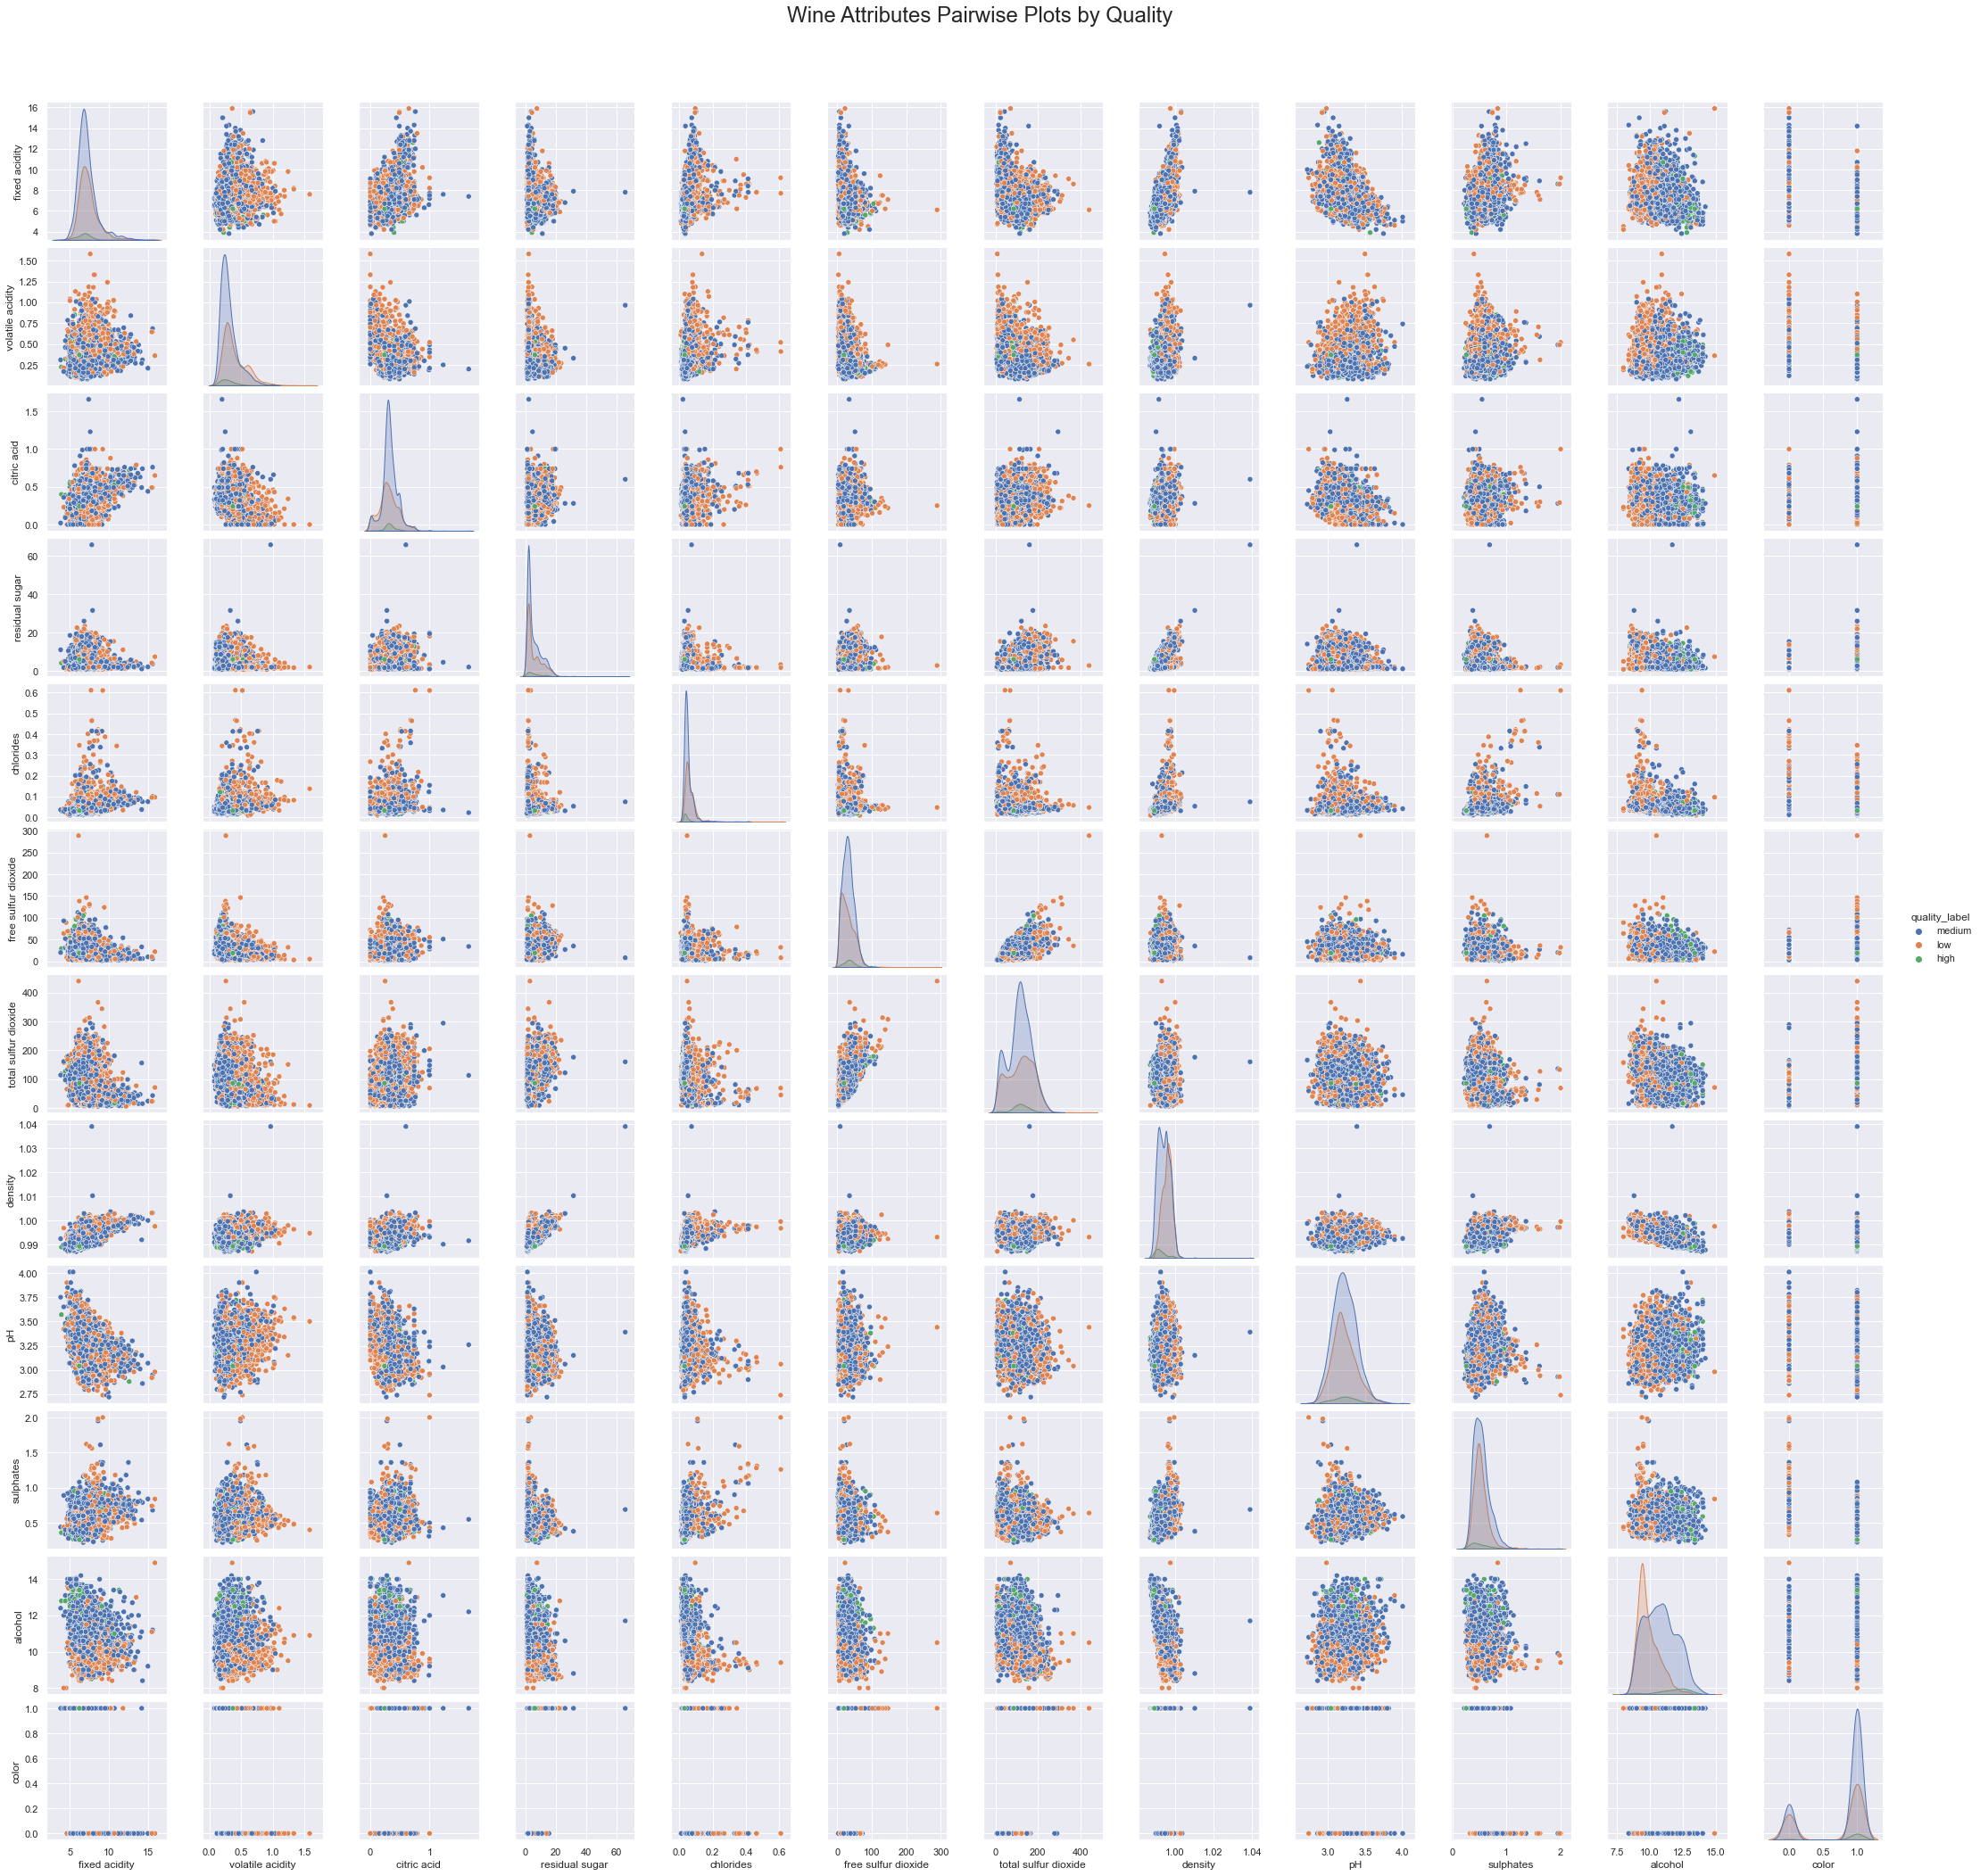

In [12]:
corr = wines.corr()
top_corr_cols = corr.quality.sort_values(ascending=False).keys() 
top_corr = corr.loc[top_corr_cols, top_corr_cols]
dropSelf = np.zeros_like(top_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
plt.figure(figsize=(18, 10))
sns.heatmap(top_corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)
sns.set(font_scale=1.5)

sns.set(font_scale=1.0)
cols = wines.columns
cols = cols.drop('quality')
g = sns.pairplot(data = wines.loc[:, cols], hue='quality_label')
fig = g.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Wine Attributes Pairwise Plots by Quality', fontsize=24)

plt.show()

del corr, dropSelf, top_corr, g, fig, t

## Data preparation


Проведем преобразование бокса-кокса

In [13]:
numeric_features = list(wines.dtypes[(wines.dtypes != "str") & (wines.dtypes !='object')].index)
numeric_features.remove('color')

skewed_features = wines[numeric_features].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

skewness = pd.DataFrame({'Skew' :skewed_features})   

skewness = skewness[abs(skewness) > 0.7]
skewness = skewness.dropna()
print ("Найдено 6 числовых признаков, нуждающихся в преобразовании Бокса-Кокса".format(skewness.shape[0]))

l_opt = {}

for feat in skewness.index:
    wines[feat], l_opt[feat] = boxcox((wines[feat]+1))

skewed_features2 = wines[skewness.index].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness2 = pd.DataFrame({'New Skew' :skewed_features2})   
display(pd.concat([skewness, skewness2], axis=1).sort_values(by=['Skew'], ascending=False))

Найдено 6 числовых признаков, нуждающихся в преобразовании Бокса-Кокса


,Skew,New Skew
chlorides,5.402178,0.188541
sulphates,1.802523,0.010381
fixed acidity,1.721248,-0.062754
volatile acidity,1.499692,0.113617
residual sugar,1.436792,0.136151
free sulfur dioxide,1.223143,-0.036825


Удалим мультиколлинеарные признаки

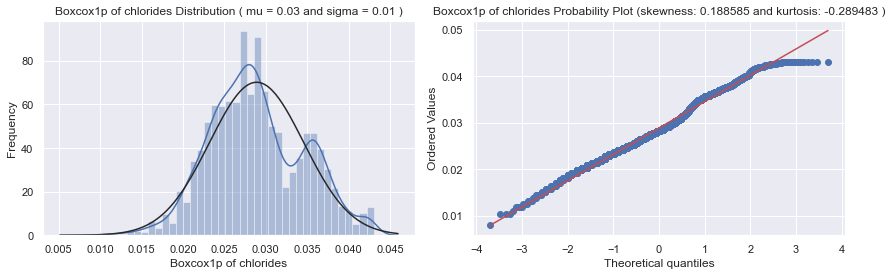

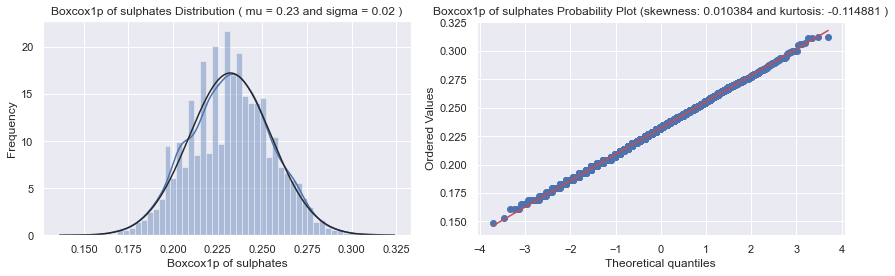

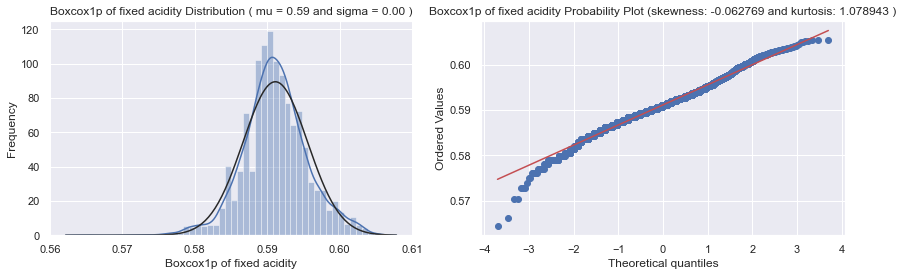

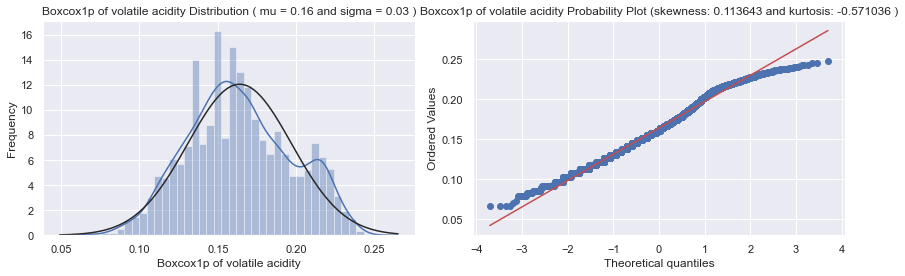

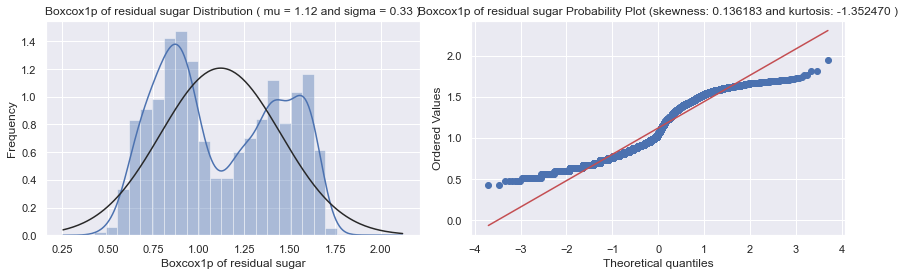

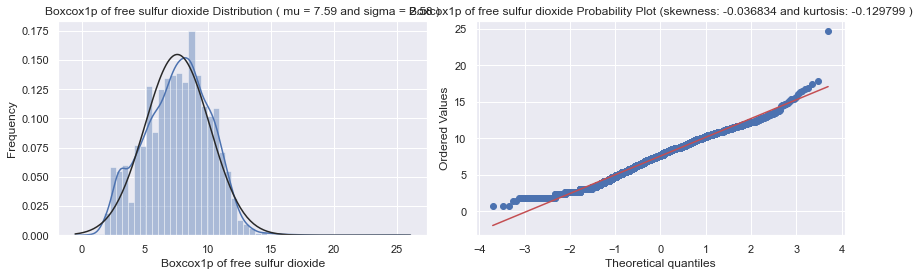

In [14]:
def QQ_plot(data, measure):
    fig = plt.figure(figsize=(12,4))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.\
                   format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()
    
for feat in skewness.index:
    QQ_plot(wines[feat], ('Boxcox1p of {}'.format(feat)))

In [15]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

def VRF(predict, data, y):
   
    scale = StandardScaler(with_std=False)
    df = pd.DataFrame(scale.fit_transform(data), columns= cols)
    features = "+".join(cols)
    df['quality_label'] = y.values

    # get y and X dataframes based on this regression:
    y, X = dmatrices(predict + ' ~' + features, data = df, return_type='dataframe')

   # Calculate VIF Factors
    # For each X, calculate VIF and save in dataframe
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns

    # Inspect VIF Factors
    display(vif.sort_values('VIF Factor'))
    return vif

cols = wines.columns.str.replace(' ', '_')
df = wines.copy()
df.columns = cols
# Remove the not applied to the qualty classification task
cols = list(cols.drop(['type', 'quality_label', 'quality']))

vif = VRF('quality_label', df.loc[:, cols], y_ql)

,VIF Factor,features
0,1.000000,Intercept
3,1.456483,citric_acid
10,1.459199,sulphates
2,1.913981,volatile_acidity
9,1.922427,pH
6,2.496617,free_sulfur_dioxide
5,2.561999,chlorides
1,2.726160,fixed_acidity
11,3.658381,alcohol
4,3.811469,residual_sugar


In [16]:
cols = wines.columns.str.replace(' ', '_')
df = wines.copy()
df.columns = cols

cols = list(cols.drop(['type', 'quality_label', 'quality', 'residual_sugar', 'total_sulfur_dioxide']))

vif = VRF('quality_label', df.loc[:, cols], y_ql)

del df, vif

,VIF Factor,features
0,1.000000,Intercept
8,1.402620,sulphates
3,1.433664,citric_acid
5,1.532415,free_sulfur_dioxide
7,1.658454,pH
2,1.809226,volatile_acidity
1,2.254045,fixed_acidity
4,2.512481,chlorides
9,2.649799,alcohol
6,3.314295,density


## Modeling

In [17]:
cols = wines.columns
cols = list(cols.drop(['type', 'quality_label', 'color']))
X_train, X_test, y_train, y_test = train_test_split(wines.loc[:, cols], y_tp, test_size=0.20, random_state=101)

Так как задание является учебным, не будем заморачиваться с самой моделью и просто переменим случайный лес

In [18]:
clf = Pipeline([
        ('pca', PCA()),
        ('clf', RandomForestClassifier(n_estimators = 100))])  

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy_score(y_pred, y_test)

0.9945862335653519

## Deployment

В нашем случае об этом говорить несколько странно)